# Anime Dataset


### Importuri

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import time

## Incarcare si afisare


In [2]:
db=pd.read_csv("top_anime_dataset.csv")
db

,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,synopsis,type,...,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",During their decade-long quest to defeat the D...,TV,...,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63200,603520,1035677
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,...,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,231928,2196353,3483268
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,...,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194507,1449844,2667979
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",Although the golden age of piracy is about to ...,TV Special,...,NaN,Toei Animation,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2350,1970,68977,91278
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense",Seeking to restore humanity's diminishing hope...,TV,...,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60500,1671010,2407861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1595,https://myanimelist.net/anime/1595/Inma_Daitos...,https://cdn.myanimelist.net/images/anime/11/13...,Inma Daitoshi: Beast City,Beast City,淫魔大都市 BEAST CITY,5.57,Hentai,The modern age. Albeit tales of strange things...,OVA,...,"Comstock, Ltd.",C and R,Light novel,41 min per ep,Rx - Hentai,NaN,10513,9,883,3021
14996,49943,https://myanimelist.net/anime/49943/Cosplay_Ch...,https://cdn.myanimelist.net/images/anime/1384/...,Cosplay Change: Pure-kei Joshidaisei no Kiken ...,NaN,コスプレチェンジ ~ピュア系女子大生の危険な性癖~,5.57,Hentai,Aima Imoko is a young college student with a h...,OVA,...,NaN,Mousou Senka,Manga,20 min per ep,Rx - Hentai,NaN,9348,8,1675,4343
14997,38812,https://myanimelist.net/anime/38812/Botsuraku,https://cdn.myanimelist.net/images/anime/1301/...,Botsuraku,NaN,没落,5.57,NaN,A short music video of the song Botsuraku by t...,Music,...,Victor Entertainment,NaN,Original,1 min,G - All Ages,NaN,18697,0,196,364
14998,38914,https://myanimelist.net/anime/38914/Papa_no_March,https://cdn.myanimelist.net/images/anime/1553/...,Papa no March,Papa's March,パパのマーチ,5.57,NaN,Official music video directed by Mitsuyuki Ish...,Music,...,NaN,NaN,Original,3 min,G - All Ages,NaN,20187,0,132,273


### Eliminare coloane si randuri

Eliminarea coloanelor:
- anime_url: link-ul catre pagina anime ului
- image_url: link-ul catre imagine
- english_name: denumirea in limba engleza
- japanese_names: denumirea in limba japoneza
- synopsis: descrierea anime ului
- premiered: cand a aparut anime ul, eliminata deoarece peste 60% din valori sunt lipsa
- rank: are o corelatie de 0.98 cu score si contine 1800 de valori NaN, din aceasta cauza am decis eliminarea ei
- scored_by: are o corelatie de 0.99 cu 'members'

In [3]:
df = db.drop(['anime_url','image_url','english_name','japanese_names','synopsis','premiered','rank','scored_by'], axis=1)
df = df[df['rating'] != 'Rx - Hentai']

### NaN procent

In [4]:
for column in df.columns:
    percentage = df[column].isnull().mean()
    print(f'{column}: {percentage:.2%}')

anime_id: 0.00%
name: 0.00%
score: 0.00%
genres: 11.62%
type: 0.01%
episodes: 0.47%
producers: 37.90%
studios: 17.02%
source: 0.00%
duration: 0.00%
rating: 0.49%
popularity: 0.00%
favorites: 0.00%
members: 0.00%


### Coloana 'duration'
- extragerea duratiei unui episod din string, convertirea acestuia la float si pe urma la int
- inlocuirea valorilor NaN cu media valorilor din coloana

In [5]:
df['duration'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration'] = df['duration'].fillna(df['duration'].mean()).astype(int)

### Coloana 'episodes'
- completare valori NaN cu media si conversia la int

In [6]:
df['episodes'] = df['episodes'].fillna(df['episodes'].mean()).astype(int)

### Coloana 'rating'
- maparea rating urilor si acordarea unui numar care semnifica varsta minima necesara pentru vizionarea animeului respectiv
- inlocuirea valorilor NaN din coloana rating cu 'Unkonown' si maparea acestuia cu -1

In [7]:
rating_mapping = {
    'G - All Ages': 0,
    'PG - Children': 8,
    'PG-13 - Teens 13 or older': 13,
    'R - 17+ (violence & profanity)': 17,
    'R+ - Mild Nudity': 18
}
df['rating'] = df['rating'].fillna('Unknown')
rating_mapping['Unknown'] = -1
df['rating'] = df['rating'].map(rating_mapping)


### Coloana 'source'

In [8]:

# Creează coloane binare pentru fiecare sursa folosind get_dummies
source_dummies = pd.get_dummies(df['source'], prefix='source').astype(int)

# Concatenează DataFrame-ul original cu DataFrame-ul surselor codificate
df = pd.concat([df, source_dummies], axis=1)

# Elimină coloana originală 'source'
df.drop(columns=['source'], inplace=True)

# Afișează DataFrame-ul rezultat
source_dummies.head()

,source_4-koma manga,source_Book,source_Card game,source_Game,source_Light novel,source_Manga,source_Mixed media,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga,source_Web novel
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Coloana 'type'


In [9]:
# Creează coloane binare pentru fiecare tip folosind get_dummies
type_dummies = pd.get_dummies(df['type'], prefix='type').astype(int)

# Concatenează DataFrame-ul original cu DataFrame-ul tipurilor codificate
df = pd.concat([df, type_dummies], axis=1)

# Elimină coloana originală 'type'
df.drop(columns=['type'], inplace=True)

# Afișează DataFrame-ul rezultat
type_dummies.head()

,type_CM,type_Movie,type_Music,type_ONA,type_OVA,type_PV,type_Special,type_TV,type_TV Special
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0


### Coloana 'genres'

In [10]:
# Înlocuiește valorile NaN din coloana 'genres' cu 'Unknown' (dacă este necesar)
df['genres'] = df['genres'].fillna('Unknown')

# Împarte valorile din coloana 'genres' în liste de genuri
df['genres'] = df['genres'].str.split(', ')

# Creează coloane binare pentru fiecare gen folosind get_dummies
genres_dummies = df['genres'].str.join('|').str.get_dummies()

# Adaugă prefixul 'genres_' la fiecare coloană generată
genres_dummies = genres_dummies.add_prefix('genres_')

# Concatenează DataFrame-ul original cu DataFrame-ul genurilor codificate
df = pd.concat([df, genres_dummies], axis=1)

# Elimină coloana originală 'genres'
df.drop(columns=['genres'], inplace=True)

# Elimină coloana 'genres_Hentai' dacă este necesar
if 'genres_Hentai' in df.columns:
    df.drop(columns=['genres_Hentai'], inplace=True)

# Afișează DataFrame-ul rezultat
genres_dummies.head()

,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,...,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,genres_Unknown
0,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Coloana 'producers'

In [11]:
# Înlocuiește valorile NaN din coloana 'producers' cu 'Unknown'
df['producers'] = df['producers'].fillna('Unknown')

# Creează coloane binare pentru fiecare producător folosind get_dummies
producers_dummies = df['producers'].str.get_dummies(sep=', ')

# Adaugă prefixul 'producers_' la fiecare coloană generată
producers_dummies = producers_dummies.add_prefix('producers_')

# Concatenează DataFrame-ul original cu DataFrame-ul producătorilor codificați
df = pd.concat([df, producers_dummies], axis=1)

# Elimină coloana originală 'producers'
df.drop(columns=['producers'], inplace=True)

producers_dummies

,producers_.MP,producers_100studio,producers_10Gauge,producers_1IN,producers_1st PLACE,producers_1theK,producers_2.5D PRODUCTION,producers_2:10 Animation,producers_3xCube,producers_5pb.,...,producers_m.o.e.,producers_miHoYoAnime,producers_monofilmo,producers_nobishiro lab,producers_pH Studio,producers_qooop,producers_studioGONG,producers_syn Sophia,producers_tamakoshi,producers_voque ting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Coloana 'studios'

In [12]:
# Înlocuiește valorile NaN din coloana 'studios' cu 'Unknown'
df['studios'] = df['studios'].fillna('Unknown')
# Creează coloane binare pentru fiecare studio folosind get_dummies
studios_dummies = df['studios'].str.get_dummies(sep=', ')
# Adaugă prefixul 'studios_' la fiecare coloană generată
studios_dummies = studios_dummies.add_prefix('studios_')
# Concatenează DataFrame-ul original cu DataFrame-ul studiourilor codificați
df = pd.concat([df, studios_dummies], axis=1)
# Elimină coloana originală 'studios'
df.drop(columns=['studios'], inplace=True)

studios_dummies

,studios_100studio,studios_10Gauge,studios_2:10 Animation,studios_5 Inc.,studios_717 Animation Studio,studios_7doc,studios_8bit,studios_A-1 Pictures,studios_A-Line,studios_A-Real,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Stergere duplicate

In [13]:
df.duplicated().sum()  # 32 duplicate
df = df.drop_duplicates()

In [14]:
df

,anime_id,name,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
0,52991,Sousou no Frieren,9.31,28,24,13,160,63200,1035677,0,...,0,0,0,0,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,9.10,64,24,17,3,231928,3483268,0,...,0,0,0,0,0,0,0,0,0,0
2,9253,Steins;Gate,9.07,24,24,13,14,194507,2667979,0,...,0,0,0,0,0,0,0,0,0,0
3,60022,One Piece Fan Letter,9.06,1,24,13,2350,1970,91278,0,...,0,0,0,0,0,0,0,0,0,0
4,38524,Shingeki no Kyojin Season 3 Part 2,9.05,10,23,17,21,60500,2407861,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,36087,Nerenai!!!,5.57,1,5,8,19849,0,291,0,...,0,0,0,0,0,0,0,0,0,0
14994,36095,Mirror Mirror (Bombs BiS),5.57,1,5,13,18111,1,410,0,...,0,0,0,0,0,0,0,0,0,0
14997,38812,Botsuraku,5.57,1,1,0,18697,0,364,0,...,0,0,0,0,0,0,0,0,0,0
14998,38914,Papa no March,5.57,1,3,0,20187,0,273,0,...,0,0,0,0,0,0,0,0,0,0


## Histograma

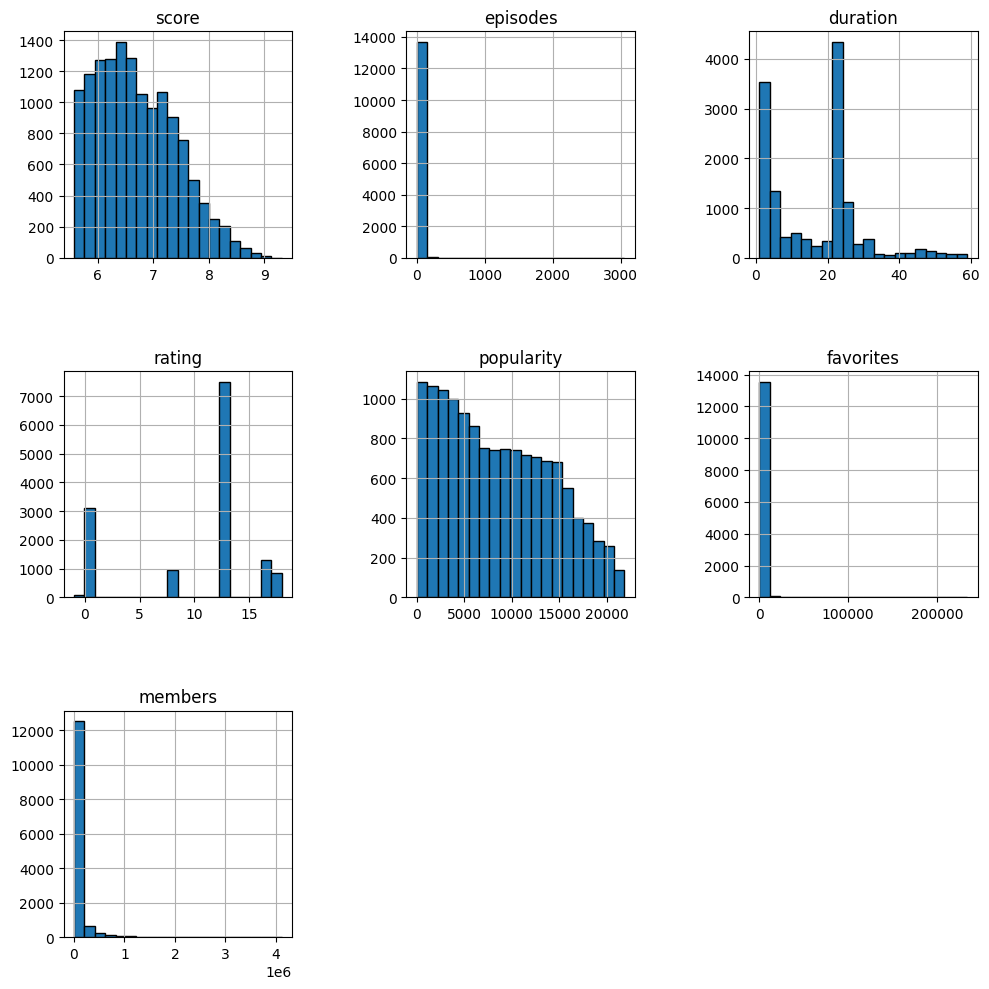

In [15]:
columns_to_plot = ['score', 'episodes', 'duration','rating','popularity','favorites','members']  
df[columns_to_plot].hist(figsize=(10, 10), bins=20, edgecolor='black')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

## Describe

In [16]:
df.describe()

,anime_id,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,source_Book,...,studios_production doA,studios_qmotri,studios_soket,studios_studio ALBLE,studios_studio MOTHER,studios_team Yamahitsuji,studios_teamKG,studios_ufotable,studios_uzupiyo Animation & Digital Works,studios_yell
count,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,1.376000e+04,13760.000000,13760.000000,...,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000
mean,25928.328997,6.697041,13.530887,16.615116,10.336555,8510.138081,871.306468,7.573820e+04,0.020422,0.006759,...,0.000291,0.000073,0.000073,0.000073,0.000581,0.000291,0.000291,0.005087,0.000073,0.000218
std,19287.980511,0.714481,52.224272,12.868265,6.068284,5674.029500,6368.066533,2.293387e+05,0.141442,0.081936,...,0.017048,0.008525,0.008525,0.008525,0.024106,0.017048,0.017048,0.071146,0.008525,0.014765
min,1.000000,5.570000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.800000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6066.250000,6.120000,1.000000,3.000000,8.000000,3539.750000,1.000000,1.397000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28622.000000,6.600000,3.000000,22.000000,13.000000,7859.500000,10.000000,6.854500e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40928.500000,7.210000,13.000000,24.000000,13.000000,13013.500000,107.000000,4.468150e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,60988.000000,9.310000,3057.000000,59.000000,18.000000,21856.000000,234344.000000,4.116124e+06,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Nul

In [17]:
df.isnull().sum()

anime_id                                     0
name                                         0
score                                        0
episodes                                     0
duration                                     0
                                            ..
studios_team Yamahitsuji                     0
studios_teamKG                               0
studios_ufotable                             0
studios_uzupiyo Animation & Digital Works    0
studios_yell                                 0
Length: 2316, dtype: int64

In [18]:
df.dtypes

anime_id                                       int64
name                                          object
score                                        float64
episodes                                       int64
duration                                       int64
                                              ...   
studios_team Yamahitsuji                       int64
studios_teamKG                                 int64
studios_ufotable                               int64
studios_uzupiyo Animation & Digital Works      int64
studios_yell                                   int64
Length: 2316, dtype: object

In [27]:
# Exclude coloanele care încep cu 'type_', 'studios_', 'producers_' sau 'genres_'
columns_to_exclude = [col for col in df.columns if col.startswith(( 'studios_', 'producers_'))]

# Exclude coloanele care nu sunt numerice
numeric_df = df.drop(columns=columns_to_exclude).select_dtypes(include=['number'])

# Calculează matricea de corelație doar pentru coloanele rămase
correlation_matrix = numeric_df.corr()

# Afișează matricea de corelație
correlation_matrix

,anime_id,score,episodes,duration,rating,popularity,favorites,members,source_4-koma manga,source_Book,...,genres_Gourmet,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,genres_Unknown
anime_id,1.000000,-0.067645,-0.078240,-0.258655,-0.036707,0.271111,-0.032831,-0.022331,-0.008527,-0.054611,...,0.032707,-0.059784,-0.040920,-0.118352,-0.212423,0.024150,-0.037628,-0.030496,0.010218,0.257391
score,-0.067645,1.000000,0.040339,0.136299,0.323240,-0.669926,0.276657,0.431802,0.012242,-0.011055,...,0.007218,-0.010637,0.145948,0.129971,0.025243,-0.015220,0.053189,0.093545,0.121546,-0.203073
episodes,-0.078240,0.040339,1.000000,0.039386,-0.048347,-0.026781,0.056594,0.042950,-0.005049,0.001947,...,0.030700,-0.010693,-0.016306,-0.008827,-0.001551,0.005252,0.012662,-0.005221,-0.011229,-0.045856
duration,-0.258655,0.136299,0.039386,1.000000,0.209698,-0.280179,0.057314,0.116934,-0.043080,-0.023864,...,0.004718,0.060827,0.056814,0.096375,0.119335,-0.036085,0.046807,0.048475,0.029361,-0.258510
rating,-0.036707,0.323240,-0.048347,0.209698,1.000000,-0.498736,0.091896,0.204115,0.027726,-0.073423,...,-0.032531,0.122029,0.144122,0.139563,0.146361,-0.146370,0.004748,0.126757,0.150274,-0.256396
popularity,0.271111,-0.669926,-0.026781,-0.280179,-0.498736,1.000000,-0.193875,-0.426535,-0.054340,0.027249,...,-0.002211,-0.054833,-0.135609,-0.223651,-0.105089,0.039543,-0.036593,-0.129272,-0.131822,0.409125
favorites,-0.032831,0.276657,0.056594,0.057314,0.091896,-0.193875,1.000000,0.771050,-0.006536,-0.010490,...,-0.005723,0.012121,0.028104,0.027924,-0.003851,-0.025031,-0.005753,0.038549,0.130368,-0.048981
members,-0.022331,0.431802,0.042950,0.116934,0.204115,-0.426535,0.771050,1.000000,-0.000193,-0.023274,...,0.007089,0.037572,0.062348,0.111250,-0.020509,-0.048797,-0.010597,0.083607,0.183646,-0.114728
source_4-koma manga,-0.008527,0.012242,-0.005049,-0.043080,0.027726,-0.054340,-0.006536,-0.000193,1.000000,-0.011910,...,0.018304,-0.023326,-0.036134,-0.024191,-0.063468,0.186158,-0.011449,-0.031756,-0.023700,-0.049091
source_Book,-0.054611,-0.011055,0.001947,-0.023864,-0.073423,0.027249,-0.010490,-0.023274,-0.011910,1.000000,...,0.001314,-0.007693,-0.016878,-0.013690,-0.023760,0.025546,-0.016959,-0.008373,-0.013540,-0.007720


### Heatmap

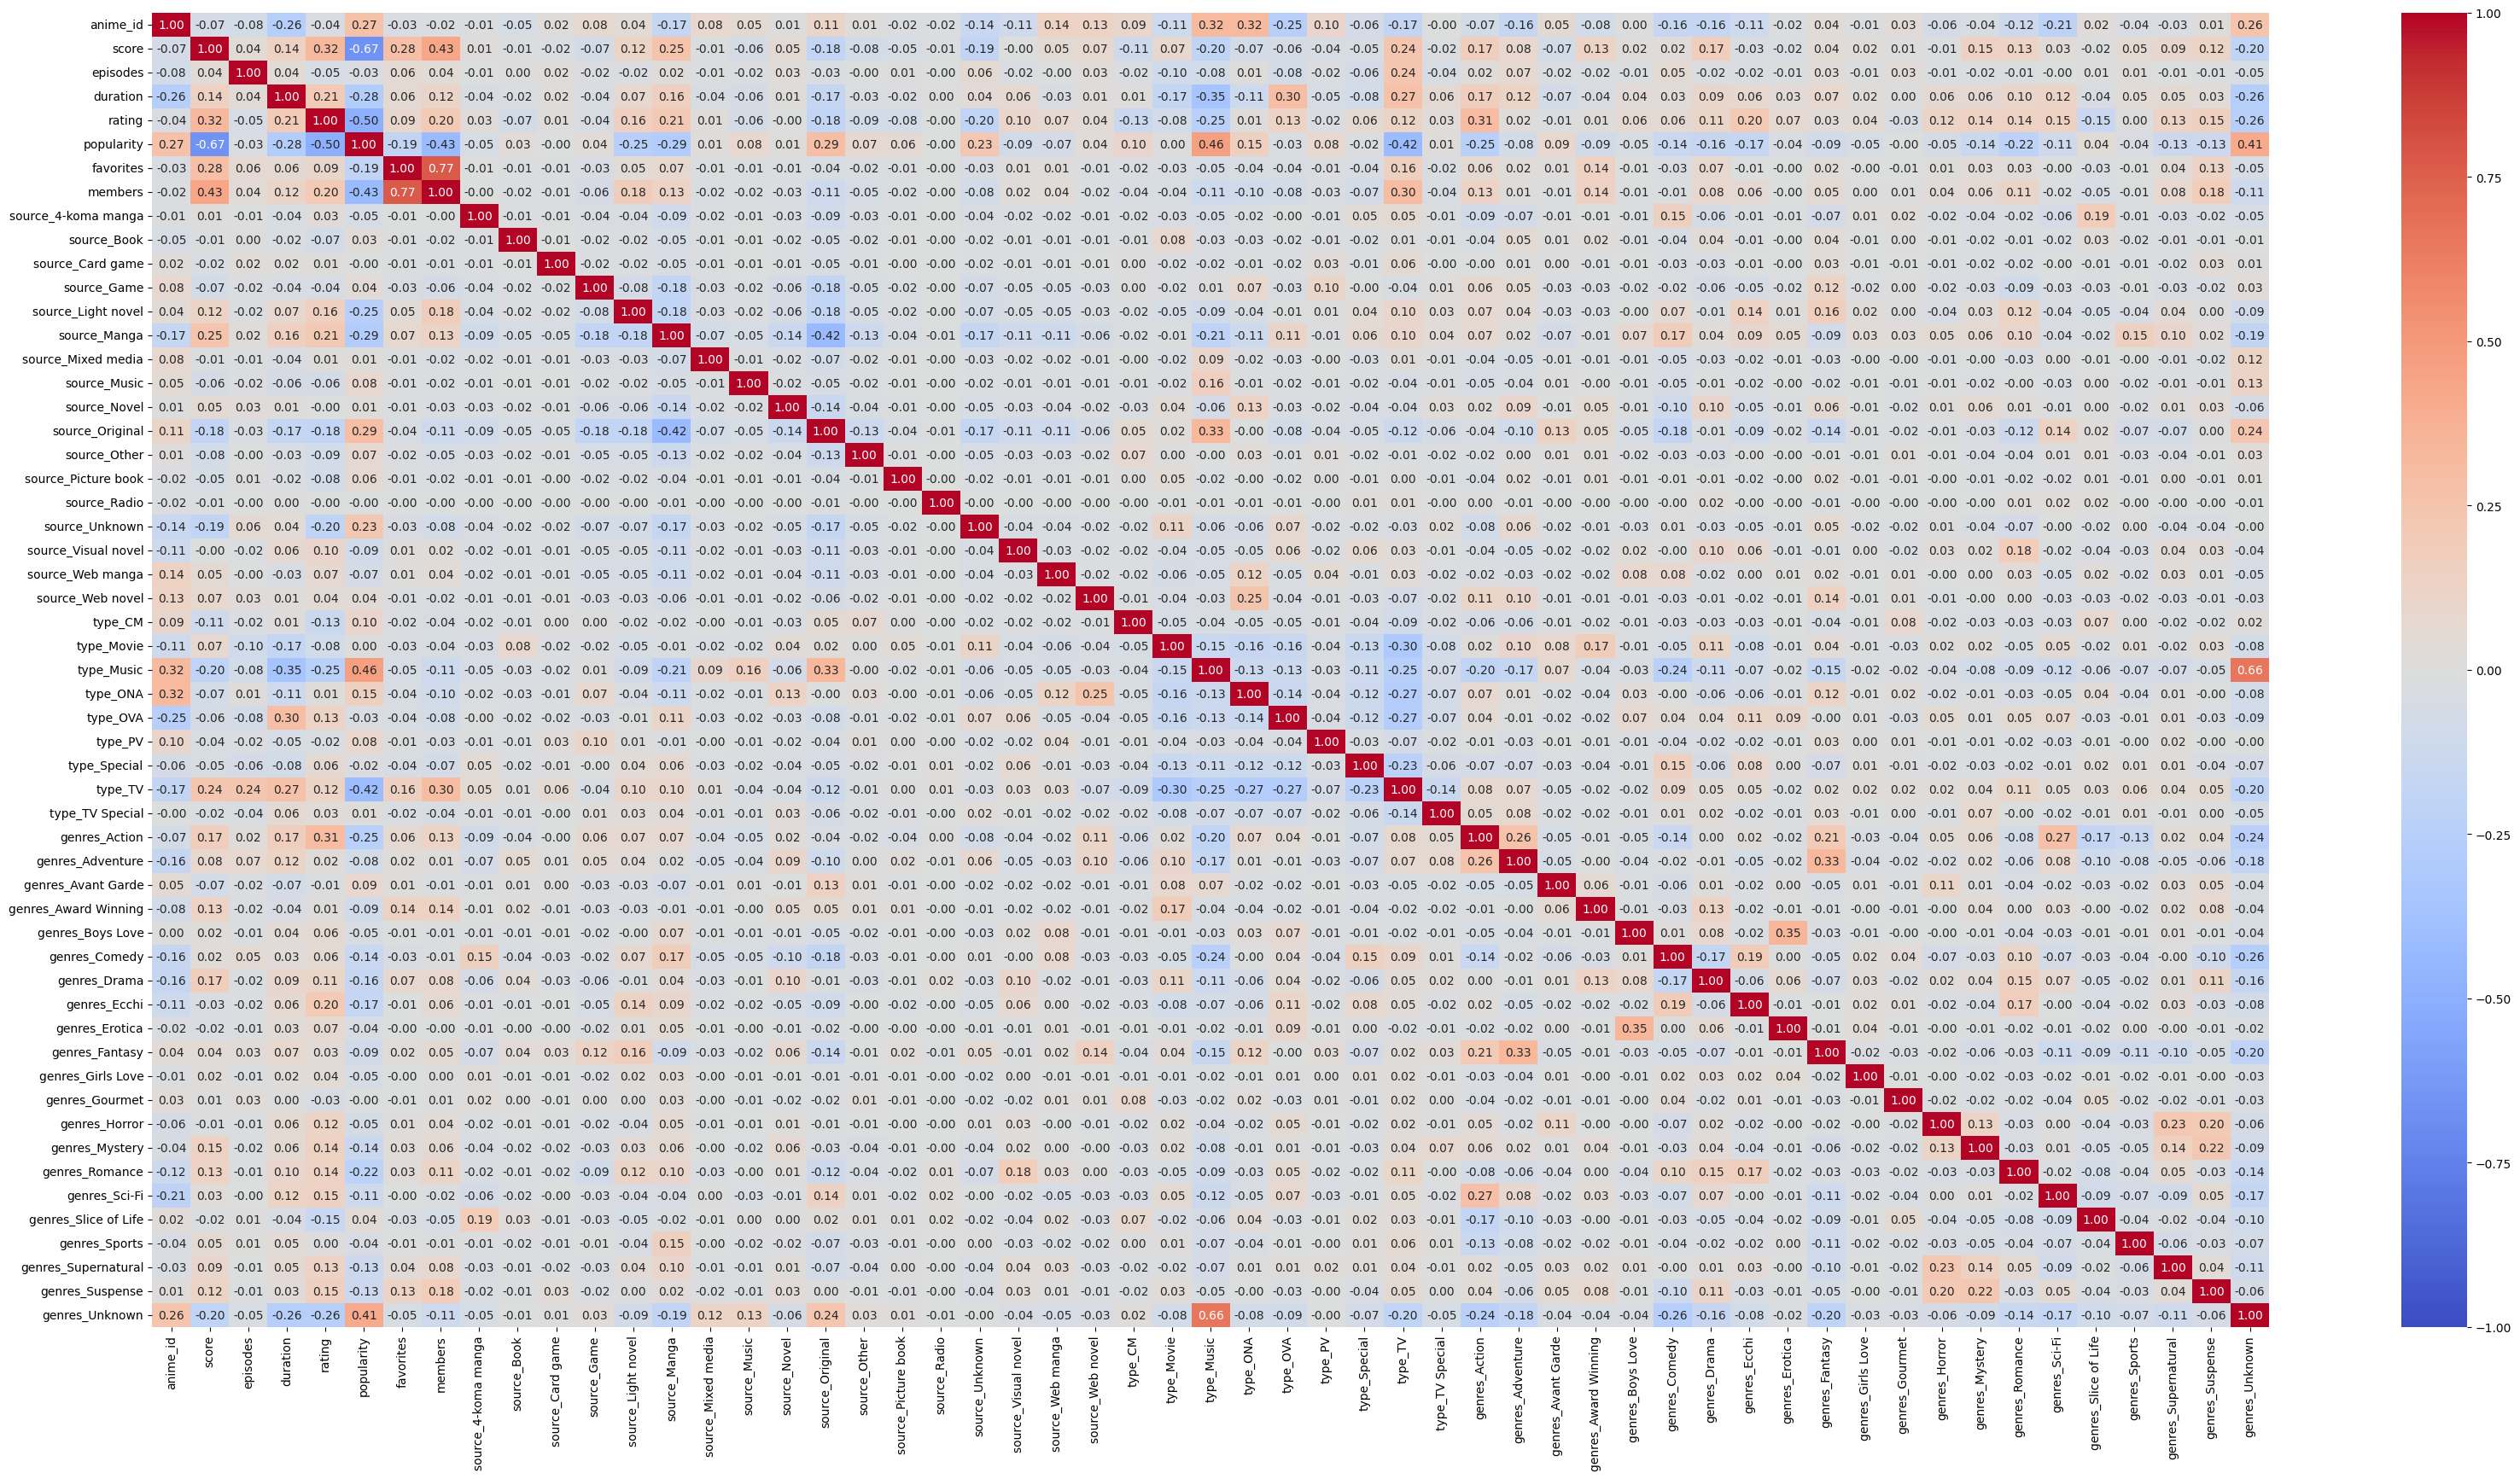

In [29]:

# Creează heatmap-ul
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Afișează heatmap-ul
plt.show()

### Explicare corelatii
- -0.67 'score' cu 'popularity': pe masura ce valoarea din popularity creste, adica devine mai putin popular, valoarea 1 insemnand cel mai popular, valoarea din coloana score tinde sa scada. Anime urile mai populare tind sa aiba un scor mai mare, fiind mai apreciate de public. Anime urile mai putin populare tind sa aiba scoruri mai mici, ce poate insemna o calitate mai scazuta sau audienta mai mica. Acestea sunt adesea legate, dar exista si factori subiectivi care influenteaza cele 2 variabile. Un anime poate avea un scor mai mare daca a fost votat de un numar mai restrans de oameni, decat daca ar fi fost votat de mai multi, si popularitatea acestuia ar fi mai mica. Sau ar putea sa creasca si scor ul cu cat este votat de mai multi oameni.
- 0.77 'members cu 'favorites': anime urile care au un numar mare de membrii ( au adaugat anime ul in listele lor de 'watching', 'completed', etc ), tind sa fie mai apreciate si adaugat in listele de favorite ale persoanelor. Un anime care are multi membrii este de regula unul popular, astfel exista mai multe sanse ca cineva sa-l considere unul din preferatele sale. Dintr-un anumit numar de membrii, doar cativa il adauga ca si favorit. Daca acest raport se pastreaza, atunci un numar mare de membrii va face ca anime ul respectiv sa fie adaugat de mai multi oameni in lista de favorite. Aceasta corelatie nu implica neaparat o cauzalitate, si arata tendinta ca anime urile care au un numar mai mare de membrii, sunt adaugate de mai multe persoane la favorite.


In [21]:
for column in df.columns:
    percentage = df[column].isnull().mean()
    print(f'{column}: {percentage:.2%}')

anime_id: 0.00%
name: 0.00%
score: 0.00%
episodes: 0.00%
duration: 0.00%
rating: 0.00%
popularity: 0.00%
favorites: 0.00%
members: 0.00%
source_4-koma manga: 0.00%
source_Book: 0.00%
source_Card game: 0.00%
source_Game: 0.00%
source_Light novel: 0.00%
source_Manga: 0.00%
source_Mixed media: 0.00%
source_Music: 0.00%
source_Novel: 0.00%
source_Original: 0.00%
source_Other: 0.00%
source_Picture book: 0.00%
source_Radio: 0.00%
source_Unknown: 0.00%
source_Visual novel: 0.00%
source_Web manga: 0.00%
source_Web novel: 0.00%
type_CM: 0.00%
type_Movie: 0.00%
type_Music: 0.00%
type_ONA: 0.00%
type_OVA: 0.00%
type_PV: 0.00%
type_Special: 0.00%
type_TV: 0.00%
type_TV Special: 0.00%
genres_Action: 0.00%
genres_Adventure: 0.00%
genres_Avant Garde: 0.00%
genres_Award Winning: 0.00%
genres_Boys Love: 0.00%
genres_Comedy: 0.00%
genres_Drama: 0.00%
genres_Ecchi: 0.00%
genres_Erotica: 0.00%
genres_Fantasy: 0.00%
genres_Girls Love: 0.00%
genres_Gourmet: 0.00%
genres_Horror: 0.00%
genres_Mystery: 0.00%
g

### Entropia


In [69]:
# Calcularea entropie
def calculate_entropy(column):
    # Obține valorile unice și numărul de apariții
    value_counts = column.value_counts()
    # Calculează entropia
    entropy_value = entropy(value_counts, base=2)
    
    return entropy_value
#episoade
episodes_entropy = calculate_entropy(df['episodes'])
print(f"Entropy for episodes: {episodes_entropy:.4f}")
#durata
duration_entropy = calculate_entropy(df['duration'])
print(f"Entropy for duration: {duration_entropy:.4f}")
#rating
rating_entropy = calculate_entropy(df['rating'])
print(f"Entropy for rating: {rating_entropy:.4f}")
#scor
score_bins = pd.cut(df['score'], bins=[5, 6, 7, 8, 9, 10], right=False)
score_entropy = calculate_entropy(score_bins)
print(f"Entropy for score: {score_entropy:.4f}")
#popularitate
popularity_bins = pd.cut(df['popularity'], bins=10, right=False)  # 10 bin-uri egale
popularity_entropy = calculate_entropy(popularity_bins)
print(f"Entropy for popularity: {popularity_entropy:.4f}")
#favorite
favorites_bins = pd.cut(df['favorites'], bins=100, right=False)  # 10 bin-uri egale
favorites_entropy = calculate_entropy(favorites_bins)
print(f"Entropy for favorites: {favorites_entropy:.4f}")
#membri
members_bins = pd.cut(df['members'], bins=10, right=False)  # 10 bin-uri egale
members_entropy = calculate_entropy(members_bins)
print(f"Entropy for members: {members_entropy:.4f}")



Entropy for episodes: 3.5463
Entropy for duration: 4.4412
Entropy for rating: 1.8329
Entropy for score: 1.7022
Entropy for popularity: 3.1980
Entropy for favorites: 0.4663
Entropy for members: 0.3376


### Gini index

In [57]:
# Funcție pentru calcularea Gini Index
def calculate_gini(column):
    # Calculează frecvențele relative ale valorilor unice
    value_counts = column.value_counts(normalize=True)
    # Calculează indicele Gini
    gini = 1 - np.sum(value_counts**2)
    return gini

#episoade
episodes_gini = calculate_gini(df['episodes'])
print(f"Gini Index for episodes: {episodes_gini:.4f}")
#durata
duration_gini = calculate_gini(df['duration'])
print(f"Gini Index for duration: {duration_gini:.4f}")
#rating
rating_gini = calculate_gini(df['rating'])
print(f"Gini Index for rating: {rating_gini:.4f}")
#scor
score_bins = pd.cut(df['score'], bins=[5, 6, 7, 8, 9, 10], right=False)
score_gini = calculate_gini(score_bins)
print(f"Gini Index for score: {score_gini:.4f}")
#popularitate
popularity_bins = pd.cut(df['popularity'], bins=10, right=False)  # 10 bin-uri egale
popularity_gini = calculate_gini(popularity_bins)
print(f"Gini Index for popularity: {popularity_gini:.4f}")
#favorite
favorites_bins = pd.cut(df['favorites'], bins=10, right=False)  # 10 bin-uri egale
favorites_gini = calculate_gini(favorites_bins)
print(f"Gini Index for favorites: {favorites_gini:.4f}")
#membri
members_bins = pd.cut(df['members'], bins=10, right=False)  # 10 bin-uri egale
members_gini = calculate_gini(members_bins)
print(f"Gini Index for members: {members_gini:.4f}")


Gini Index for episodes: 0.7750
Gini Index for duration: 0.9208
Gini Index for rating: 0.6345
Gini Index for score: 0.6540
Gini Index for popularity: 0.8847
Gini Index for favorites: 0.0160
Gini Index for members: 0.0845


In [74]:
print(sorted(df['members'].unique().tolist()))
print(len(df['members'].unique()))
print(sorted(df['favorites'].unique().tolist()))
print(len(df['favorites'].unique()))
print(sorted(df['popularity'].unique().tolist()))
print(len(df['popularity'].unique()))
print(sorted(df['rating'].unique().tolist()))
print(df['rating'].value_counts())

[180, 188, 191, 193, 194, 199, 200, 201, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,